# Tutorial 4 (JAX): Optimization and Initialization

![Status](https://img.shields.io/static/v1.svg?label=Status&message=Finished&color=green)

**Filled notebook:** 
[![View on Github](https://img.shields.io/static/v1.svg?logo=github&label=Repo&message=View%20On%20Github&color=lightgrey)](https://github.com/phlippe/uvadlc_notebooks/blob/master/docs/tutorial_notebooks/JAX/tutorial4/Optimization_and_Initialization.ipynb)
[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/phlippe/uvadlc_notebooks/blob/master/docs/tutorial_notebooks/JAX/tutorial4/Optimization_and_Initialization.ipynb)    
**Pre-trained models:** 
[![View files on Github](https://img.shields.io/static/v1.svg?logo=github&label=Repo&message=View%20On%20Github&color=lightgrey)](https://github.com/phlippe/saved_models/tree/main/JAX/tutorial4)    
**PyTorch version:**
[![View on RTD](https://img.shields.io/static/v1.svg?logo=readthedocs&label=RTD&message=View%20On%20RTD&color=8CA1AF)](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial4/Optimization_and_Initialization.html)   
**Author:** Phillip Lippe

<div class="alert alert-info">

**Note:** This notebook is written in JAX+Flax. It is a 1-to-1 translation of the original notebook written in PyTorch+PyTorch Lightning with almost identical results. For an introduction to JAX, check out our [Tutorial 2 (JAX): Introduction to JAX+Flax](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/JAX/tutorial2/Introduction_to_JAX.html). Further, throughout the notebook, we comment on major differences to the PyTorch version and provide explanations for the major parts of the JAX code. We do not provide speed comparisons for this notebook since they tend to be uninformative for such small networks and potentially bottlenecked by other factors.
    
</div>

In this tutorial, we will review techniques for optimization and initialization of neural networks. When increasing the depth of neural networks, there are various challenges we face. Most importantly, we need to have a stable gradient flow through the network, as otherwise, we might encounter vanishing or exploding gradients. This is why we will take a closer look at the following concepts: initialization and optimization.

In the first half of the notebook, we will review different initialization techniques, and go step by step from the simplest initialization to methods that are nowadays used in very deep networks. In the second half, we focus on optimization comparing the optimizers SGD, SGD with Momentum, and Adam. 

Let's start with importing our standard libraries:

In [1]:
## Standard libraries
import os
import json
import math
import numpy as np 
import copy
from typing import Any, Sequence, Callable, NamedTuple, Optional, Tuple
PyTree = Any  # Type definition for PyTree, for readability
from copy import deepcopy
import pickle

## Imports for plotting
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline 
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
import seaborn as sns
sns.set()

## Progress bar
from tqdm.auto import tqdm

## JAX
import jax
import jax.numpy as jnp
from jax import random
from jax.tree_util import tree_map

## Flax (NN in JAX)
import flax
from flax import linen as nn
from flax.training import train_state, checkpoints
import optax


/tmp/ipykernel_56600/1194704090.py:17: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export
2022-10-17 15:20:27.098612: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-17 15:20:27.839231: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/sander/Downloads/tensorrt/lib:/home/sander/Downloads/cudnn/cuda/lib64/
2022-10-17 15:20:27.839316: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or dir

We will use the same path variables `DATASET_PATH` and `CHECKPOINT_PATH` as in Tutorial 3. Adjust the paths if necessary.

In [2]:
# Path to the folder where the datasets are/should be downloaded (e.g. MNIST)
DATASET_PATH = "./data"
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "./saved_models/tutorial4_jax"

# Verifying the device that will be used throughout this notebook
print("Device:", jax.devices()[0])

Device: TFRT_CPU_0


In the last part of the notebook, we will train models using three different optimizers. The pretrained models for those are downloaded below.

In [3]:
import urllib.request
from urllib.error import HTTPError
# Github URL where saved models are stored for this tutorial
base_url = "https://raw.githubusercontent.com/phlippe/saved_models/main/JAX/tutorial4/"
# Files to download
pretrained_files = ["FashionMNIST_SGD.config",    "FashionMNIST_SGD_results.json",    "FashionMNIST_SGD.tar", 
                    "FashionMNIST_SGDMom.config", "FashionMNIST_SGDMom_results.json", "FashionMNIST_SGDMom.tar", 
                    "FashionMNIST_Adam.config",   "FashionMNIST_Adam_results.json",   "FashionMNIST_Adam.tar"   ]
# Create checkpoint path if it doesn't exist yet
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

# For each file, check whether it already exists. If not, try downloading it.
for file_name in pretrained_files:
    file_path = os.path.join(CHECKPOINT_PATH, file_name)
    if not os.path.isfile(file_path):
        file_url = base_url + file_name
        print(f"Downloading {file_url}...")
        try:
            urllib.request.urlretrieve(file_url, file_path)
        except HTTPError as e:
            print("Something went wrong. Please try to download the file from the GDrive folder, or contact the author with the full output including the following error:\n", e)

## Preparation

Throughout this notebook, we will use a deep fully connected network, similar to our previous tutorial. We will also again apply the network to FashionMNIST, so you can relate to the results of Tutorial 3. 
We start by loading the FashionMNIST dataset:

In [4]:
import torch
import torch.utils.data as data
from torchvision.datasets import FashionMNIST
from torchvision import transforms


# Transformations applied on each image => bring them into a numpy array and normalize to mean 0 and std 1
def image_to_numpy(img):
    img = np.array(img, dtype=np.float32)
    img = (img / 255. - 0.2861) / 0.3530
    return img

# We need to stack the batch elements as numpy arrays
def numpy_collate(batch):
    if isinstance(batch[0], np.ndarray):
        return np.stack(batch)
    elif isinstance(batch[0], (tuple,list)):
        transposed = zip(*batch)
        return [numpy_collate(samples) for samples in transposed]
    else:
        return np.array(batch)

# Loading the training dataset. We need to split it into a training and validation part
train_dataset = FashionMNIST(root=DATASET_PATH,
                             train=True,
                             transform=image_to_numpy,
                             download=True)
train_set, val_set = torch.utils.data.random_split(train_dataset,
                                                   [50000, 10000],
                                                   generator=torch.Generator().manual_seed(42))

# Loading the test set
test_set = FashionMNIST(root=DATASET_PATH,
                        train=False,
                        transform=image_to_numpy,
                        download=True)

# We define a set of data loaders that we can use for various purposes later.
# Note that for actually training a model, we will use different data loaders
# with a lower batch size.
train_loader = data.DataLoader(train_set,
                               batch_size=1024,
                               shuffle=False,
                               drop_last=False,
                               collate_fn=numpy_collate)
val_loader   = data.DataLoader(val_set,
                               batch_size=1024,
                               shuffle=False,
                               drop_last=False,
                               collate_fn=numpy_collate)
test_loader  = data.DataLoader(test_set,
                               batch_size=1024,
                               shuffle=False,
                               drop_last=False,
                               collate_fn=numpy_collate)

In comparison to the previous tutorial, we have changed the parameters of the normalization transformation in `image_to_numpy`. The normalization is now designed to give us an expected mean of 0 and a standard deviation of 1 across pixels. This will be particularly relevant for the discussion about initialization we will look at below, and hence we change it here. It should be noted that in most classification tasks, both normalization techniques (between -1 and 1 or mean 0 and stddev 1) have shown to work well.
We can calculate the normalization parameters by determining the mean and standard deviation on the original images:

In [5]:
print("Mean", (train_dataset.data.float() / 255.0).mean().item())
print("Std", (train_dataset.data.float() / 255.0).std().item())

Mean 0.28604060411453247
Std 0.3530242443084717


We can verify the transformation by looking at the statistics of a single batch:

In [6]:
imgs, _ = next(iter(train_loader))
print(f"Mean: {imgs.mean().item():5.3f}")
print(f"Standard deviation: {imgs.std().item():5.3f}")
print(f"Maximum: {imgs.max().item():5.3f}")
print(f"Minimum: {imgs.min().item():5.3f}")

Mean: 0.008
Standard deviation: 1.009
Maximum: 2.022
Minimum: -0.810


Note that the maximum and minimum are not 1 and -1 anymore, but shifted towards the positive values. This is because FashionMNIST contains a lot of black pixels, similar to MNIST.

Next, we create a linear neural network. We use the same setup as in the previous tutorial. 

In [7]:
# Network
class BaseNetwork(nn.Module):
    act_fn : Callable
    num_classes : int = 10
    hidden_sizes : Sequence = (512, 256, 256, 128)
    kernel_init : Callable = nn.linear.default_kernel_init

    @nn.compact
    def __call__(self, x, return_activations=False):
        x = x.reshape(x.shape[0], -1) # Reshape images to a flat vector
        # We collect all activations throughout the network for later visualizations
        # Remember that in jitted functions, unused tensors will anyways be removed.
        activations = []
        for hd in self.hidden_sizes:
            x = nn.Dense(hd,
                         kernel_init=self.kernel_init)(x)
            activations.append(x)
            x = self.act_fn(x)
            activations.append(x)
        x = nn.Dense(self.num_classes,
                     kernel_init=self.kernel_init)(x)
        activations.append(x)
        return x if not return_activations else (x, activations)

For the activation functions, we make use of JAX's and Flax's library instead of implementing ourselves. However, we also define an `Identity` activation function. Although this activation function would significantly limit the network's modeling capabilities, we will use it in the first steps of our discussion about initialization (for simplicity). 

In [8]:
act_fn_by_name = {
    "tanh": nn.tanh,
    "relu": nn.relu,
    "identity": lambda x: x
}

Finally, we define a few plotting functions that we will use for our discussions. These functions help us to (1) visualize the weight/parameter distribution inside a network, (2) visualize the gradients that the parameters at different layers receive, and (3) the activations, i.e. the output of the linear layers. The detailed code is not important, but feel free to take a closer look if interested.

In [9]:
##############################################################

def plot_dists(val_dict, color="C0", xlabel=None, stat="count", use_kde=True):
    columns = len(val_dict)
    fig, ax = plt.subplots(1, columns, figsize=(columns*3, 2.5))
    fig_index = 0
    for key in sorted(val_dict.keys()):
        key_ax = ax[fig_index%columns]
        sns.histplot(val_dict[key], ax=key_ax, color=color, bins=50, stat=stat,
                     kde=use_kde and ((val_dict[key].max()-val_dict[key].min())>1e-8)) # Only plot kde if there is variance
        key_ax.set_title(f"{key} " + (r"(%i $\to$ %i)" % (val_dict[key].shape[1], val_dict[key].shape[0]) if len(val_dict[key].shape)>1 else ""))
        if xlabel is not None:
            key_ax.set_xlabel(xlabel)
        fig_index += 1
    fig.subplots_adjust(wspace=0.4)
    return fig
 
##############################################################

def visualize_weight_distribution(params, color="C0"):
    params, _ = jax.tree_util.tree_flatten(params)
    params = [p.reshape(-1) for p in params if len(p.shape) > 1]  # Remove biases
    params = jax.device_get(params)
    weights = {f'Layer {layer_idx*2}': p for layer_idx, p in enumerate(params)}
    
    ## Plotting
    fig = plot_dists(weights, color=color, xlabel="Weight vals")
    fig.suptitle("Weight distribution", fontsize=14, y=1.05)
    plt.show()
    plt.close() 
    
##############################################################

small_loader = data.DataLoader(train_set, batch_size=1024, shuffle=False, collate_fn=numpy_collate)
exmp_imgs, exmp_labels = next(iter(small_loader))

def visualize_gradients(model, params, color="C0", print_variance=False):
    """
    Inputs:
        net - Object of class BaseNetwork
        color - Color in which we want to visualize the histogram (for easier separation of activation functions)
    """
    # Pass one batch through the network, and calculate the gradients for the weights
    def loss_func(p):
        logits = model.apply(p, exmp_imgs)
        loss = optax.softmax_cross_entropy_with_integer_labels(logits, exmp_labels).mean()
        return loss
    grads = jax.grad(loss_func)(params)
    grads = jax.device_get(grads)
    # We limit our visualization to the weight parameters and exclude the bias to reduce the number of plots
    grads = jax.tree_util.tree_leaves(grads)
    grads = [g.reshape(-1) for g in grads if len(g.shape) > 1]
    grads = {f'Layer {layer_idx*2}': g for layer_idx, g in enumerate(grads)}
    
    ## Plotting
    fig = plot_dists(grads, color=color, xlabel="Grad magnitude")
    fig.suptitle("Gradient distribution", fontsize=14, y=1.05)
    plt.show()
    plt.close() 
    
    if print_variance:
        for key in sorted(grads.keys()):
            print(f"{key} - Variance: {np.var(grads[key])}")

##############################################################

def visualize_activations(model, params, color="C0", print_variance=False):
    # Pass one batch through the network, and calculate the activations
    _, activations = model.apply(params, exmp_imgs, return_activations=True)
    activations = {f'Layer {layer_idx*2}': act.reshape(-1) for layer_idx, act in enumerate(activations[::2])}
    
    ## Plotting
    fig = plot_dists(activations, color=color, stat="density", xlabel="Activation vals")
    fig.suptitle("Activation distribution", fontsize=14, y=1.05)
    plt.show()
    plt.close() 
    
    if print_variance:
        for key in sorted(activations.keys()):
            print(f"{key} - Variance: {np.var(activations[key])}")

            
##############################################################

## Initialization

Before starting our discussion about initialization, it should be noted that there exist many very good blog posts about the topic of neural network initialization (for example [deeplearning.ai](https://www.deeplearning.ai/ai-notes/initialization/), or a more [math-focused blog post](https://pouannes.github.io/blog/initialization/#mjx-eqn-eqfwd_K)). In case something remains unclear after this tutorial, we recommend skimming through these blog posts as well.

When initializing a neural network, there are a few properties we would like to have. First, the variance of the input should be propagated through the model to the last layer, so that we have a similar standard deviation for the output neurons. If the variance would vanish the deeper we go in our model, it becomes much harder to optimize the model as the input to the next layer is basically a single constant value. Similarly, if the variance increases, it is likely to explode (i.e. head to infinity) the deeper we design our model. The second property we look out for in initialization techniques is a gradient distribution with equal variance across layers. If the first layer receives much smaller gradients than the last layer, we will have difficulties in choosing an appropriate learning rate. 

As a starting point for finding a good method, we will analyze different initialization based on our linear neural network with no activation function (i.e. an identity). We do this because initializations depend on the specific activation function used in the network, and we can adjust the initialization schemes later on for our specific choice.

In [10]:
def init_simple_model(kernel_init, act_fn=act_fn_by_name['identity']):
    model = BaseNetwork(act_fn=act_fn,
                        kernel_init=kernel_init)
    params = model.init(random.PRNGKey(42), exmp_imgs)
    return model, params

Note that in contrast to the [PyTorch version](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial4/Optimization_and_Initialization.html) of this tutorial, we keep the bias initialization fixed. As the default, JAX uses a zero initialization. In practice, the initialization of the bias is less relevant as long as it is reasonably close to zero, since it is only a (learnable) constant added to the features.

### Constant initialization

The first initialization we can consider is to initialize all weights with the same constant value. Intuitively, setting all weights to zero is not a good idea as the propagated gradient will be zero. However, what happens if we set all weights to a value slightly larger or smaller than 0? To find out, we can implement a function for setting all parameters below and visualize the gradients.

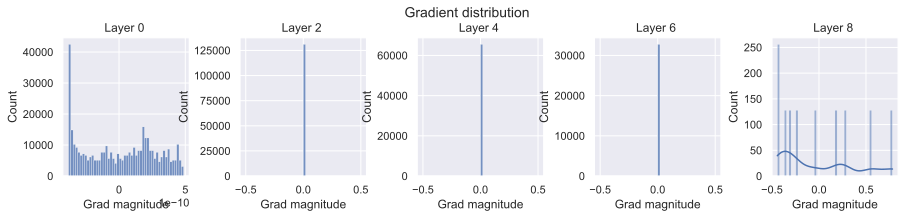

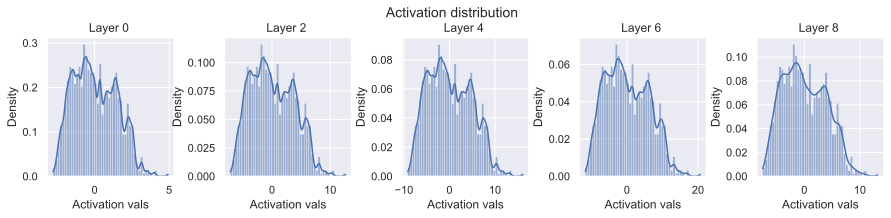

Layer 0 - Variance: 2.0582761764526367
Layer 2 - Variance: 13.489112854003906
Layer 4 - Variance: 22.10055923461914
Layer 6 - Variance: 36.20954895019531
Layer 8 - Variance: 14.831430435180664


In [11]:
# An initialization function in JAX takes as input a PRNG key,
# the shape of the parameter to create, and the data type 
# (usually jnp.float32). We create this function based on the
# input parameter 'c' here, indicating the constant value
def get_const_init_func(c=0.0):
    return lambda key, shape, dtype: c*jnp.ones(shape, dtype=dtype)

model, params = init_simple_model(get_const_init_func(c=0.005))
visualize_gradients(model, params)
visualize_activations(model, params, print_variance=True)

As we can see, only the first and the last layer have diverse gradient distributions while the other three layers have the same gradient for all weights (note that this value is unequal 0, but often very close to it). Having the same gradient for parameters that have been initialized with the same values means that we will always have the same value for those parameters. This would make our layer useless and reduce our effective number of parameters to 1. Thus, we cannot use a constant initialization to train our networks.

### Constant variance

From the experiment above, we have seen that a constant value is not working. So instead, how about we initialize the parameters by randomly sampling from a distribution like a Gaussian? The most intuitive way would be to choose one variance that is used for all layers in the network. Let's implement it below, and visualize the activation distribution across layers.

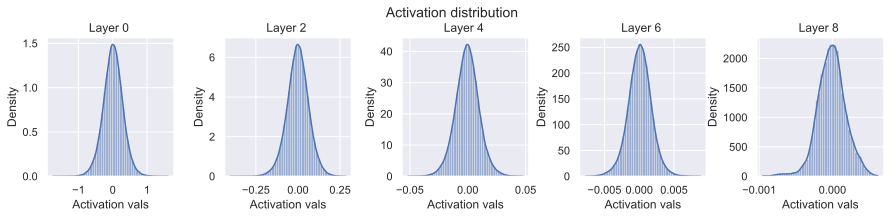

Layer 0 - Variance: 0.08219309151172638
Layer 2 - Variance: 0.00415463000535965
Layer 4 - Variance: 0.00010465683590155095
Layer 6 - Variance: 2.8326080609986093e-06
Layer 8 - Variance: 3.754524158239292e-08


In [12]:
def get_var_init_func(std=0.01):
    return lambda key, shape, dtype: std*random.normal(key, shape, dtype=dtype)
        
model, params = init_simple_model(get_var_init_func(std=0.01))
visualize_activations(model, params, print_variance=True)

The variance of the activation becomes smaller and smaller across layers, and almost vanishes in the last layer. Alternatively, we could use a higher standard deviation:

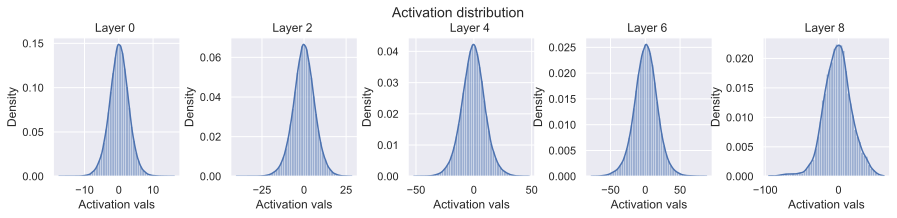

Layer 0 - Variance: 8.219310760498047
Layer 2 - Variance: 41.546302795410156
Layer 4 - Variance: 104.6568603515625
Layer 6 - Variance: 283.2608947753906
Layer 8 - Variance: 375.4525451660156


In [13]:
model, params = init_simple_model(get_var_init_func(std=0.1))
visualize_activations(model, params, print_variance=True)

With a higher standard deviation, the activations are likely to explode. You can play around with the specific standard deviation values, but it will be hard to find one that gives us a good activation distribution across layers and is very specific to our model. If we would change the hidden sizes or number of layers, you would have to search all over again, which is neither efficient nor recommended.

### How to find appropriate initialization values

From our experiments above, we have seen that we need to sample the weights from a distribution, but are not sure which one exactly. As a next step, we will try to find the optimal initialization from the perspective of the activation distribution. For this, we state two requirements:

1. The mean of the activations should be zero
2. The variance of the activations should stay the same across every layer

Suppose we want to design an initialization for the following layer: $y=Wx+b$ with $y\in\mathbb{R}^{d_y}$, $x\in\mathbb{R}^{d_x}$. Our goal is that the variance of each element of $y$ is the same as the input, i.e. $\text{Var}(y_i)=\text{Var}(x_i)=\sigma_x^{2}$, and that the mean is zero. We assume $x$ to also have a mean of zero, because, in deep neural networks, $y$ would be the input of another layer. This requires the bias and weight to have an expectation of 0. Actually, as $b$ is a single element per output neuron and is constant across different inputs, we set it to 0 overall.

Next, we need to calculate the variance with which we need to initialize the weight parameters. 
Along the calculation, we will need the following variance rule: given two independent variables, the variance of their product is $\text{Var}(X\cdot Y) = \mathbb{E}(Y)^2\text{Var}(X) + \mathbb{E}(X)^2\text{Var}(Y) + \text{Var}(X)\text{Var}(Y) = \mathbb{E}(Y^2)\mathbb{E}(X^2)-\mathbb{E}(Y)^2\mathbb{E}(X)^2$ ($X$ and $Y$ are not refering to $x$ and $y$, but any random variable). 

The needed variance of the weights, $\text{Var}(w_{ij})$, is calculated as follows:

$$
\begin{split}
    y_i & = \sum_{j} w_{ij}x_{j}\hspace{10mm}\text{Calculation of a single output neuron without bias}\\
    \text{Var}(y_i) = \sigma_x^{2} & = \text{Var}\left(\sum_{j} w_{ij}x_{j}\right)\\
    & = \sum_{j} \text{Var}(w_{ij}x_{j}) \hspace{10mm}\text{Inputs and weights are independent of each other}\\
    & = \sum_{j} \text{Var}(w_{ij})\cdot\text{Var}(x_{j}) \hspace{10mm}\text{Variance rule (see above) with expectations being zero}\\
    & = d_x \cdot \text{Var}(w_{ij})\cdot\text{Var}(x_{j}) \hspace{10mm}\text{Variance equal for all $d_x$ elements}\\
    & = \sigma_x^{2} \cdot d_x \cdot \text{Var}(w_{ij})\\
    \Rightarrow \text{Var}(w_{ij}) = \sigma_{W}^2 & = \frac{1}{d_x}\\
\end{split}
$$

Thus, we should initialize the weight distribution with a variance of the inverse of the input dimension $d_x$. Let's implement it below and check whether this holds:

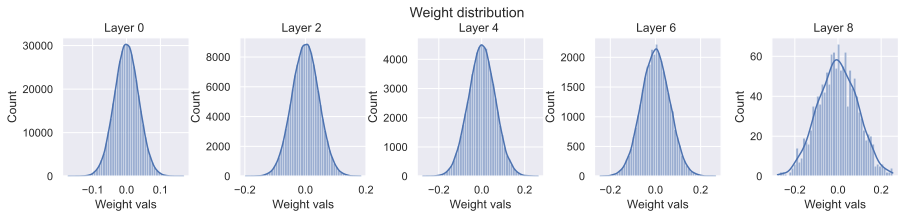

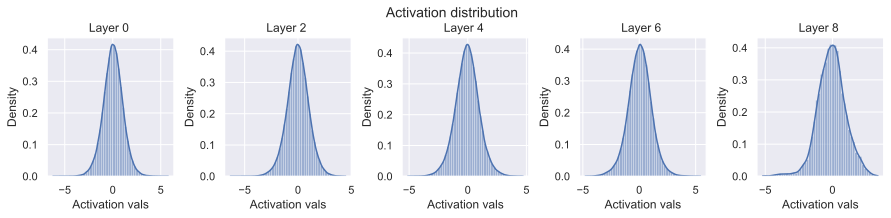

Layer 0 - Variance: 1.0483813285827637
Layer 2 - Variance: 1.0350143909454346
Layer 4 - Variance: 1.0184545516967773
Layer 6 - Variance: 1.0767642259597778
Layer 8 - Variance: 1.1150106191635132


In [14]:
equal_var_init = lambda key, shape, dtype: 1.0/np.sqrt(shape[0]) * random.normal(key, shape, dtype=dtype)
        
model, params = init_simple_model(equal_var_init)
visualize_weight_distribution(params)
visualize_activations(model, params, print_variance=True)

As we expected, the variance stays indeed constant across layers. Note that our initialization does not restrict us to a normal distribution, but allows any other distribution with a mean of 0 and variance of $1/d_x$. You often see that a uniform distribution is used for initialization. A small benefit of using a uniform instead of a normal distribution is that we can exclude the chance of initializing very large or small weights.

Besides the variance of the activations, another variance we would like to stabilize is the one of the gradients. This ensures a stable optimization for deep networks. It turns out that we can do the same calculation as above starting from $\Delta x=W\Delta y$, and come to the conclusion that we should initialize our layers with $1/d_y$ where $d_y$ is the number of output neurons. You can do the calculation as a practice, or check a thorough explanation in [this blog post](https://pouannes.github.io/blog/initialization/#mjx-eqn-eqfwd_K). As a compromise between both constraints, [Glorot and Bengio (2010)](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf?hc_location=ufi) proposed to use the harmonic mean of both values. This leads us to the well-known Xavier initialization:

$$W\sim \mathcal{N}\left(0,\frac{2}{d_x+d_y}\right)$$

If we use a uniform distribution, we would initialize the weights with:

$$W\sim U\left[-\frac{\sqrt{6}}{\sqrt{d_x+d_y}}, \frac{\sqrt{6}}{\sqrt{d_x+d_y}}\right]$$

Let's shortly implement it and validate its effectiveness:

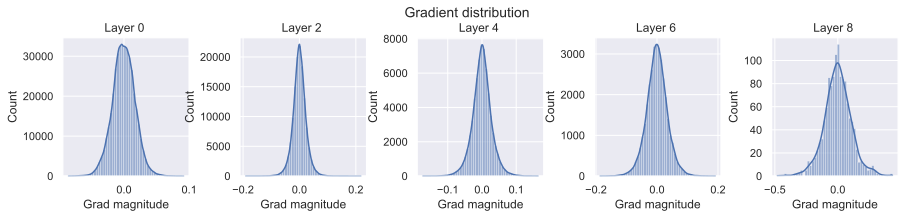

Layer 0 - Variance: 0.00029831365100108087
Layer 2 - Variance: 0.0005463268025778234
Layer 4 - Variance: 0.0007796576828695834
Layer 6 - Variance: 0.0011752902064472437
Layer 8 - Variance: 0.011736483313143253


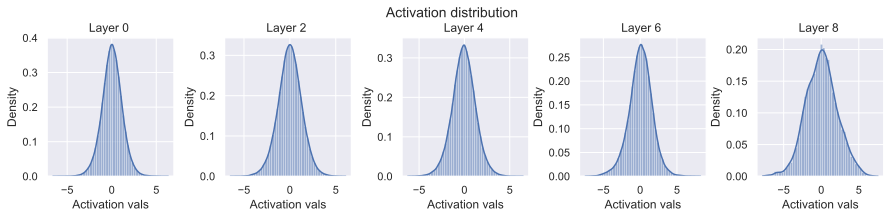

Layer 0 - Variance: 1.2806072235107422
Layer 2 - Variance: 1.6784099340438843
Layer 4 - Variance: 1.6767947673797607
Layer 6 - Variance: 2.5439999103546143
Layer 8 - Variance: 4.41333532333374


In [15]:
def xavier_init(key, shape, dtype):
    bound = math.sqrt(6)/math.sqrt(shape[0]+shape[1])
    return random.uniform(key, shape, dtype,
                          minval=-bound, maxval=bound)

model, params = init_simple_model(xavier_init)
visualize_gradients(model, params, print_variance=True)
visualize_activations(model, params, print_variance=True)

We see that the Xavier initialization balances the variance of gradients and activations. Note that the significantly higher variance for the output layer is due to the large difference of input and output dimension ($128$ vs $10$). However, we currently assumed the activation function to be linear. So what happens if we add a non-linearity? In a tanh-based network, a common assumption is that for small values during the initial steps in training, the $\tanh$ works as a linear function such that we don't have to adjust our calculation. We can check if that is the case for us as well:

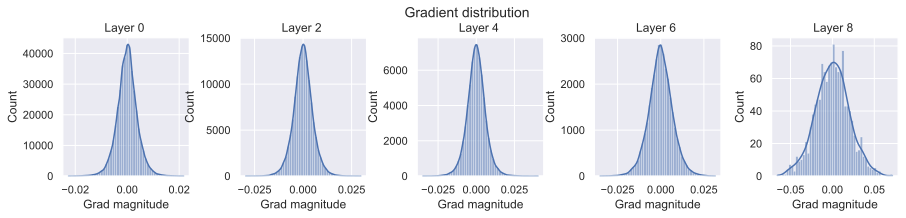

Layer 0 - Variance: 1.520933165011229e-05
Layer 2 - Variance: 2.4512755771866068e-05
Layer 4 - Variance: 3.6233024729881436e-05
Layer 6 - Variance: 4.8036039515864104e-05
Layer 8 - Variance: 0.0004025915695820004


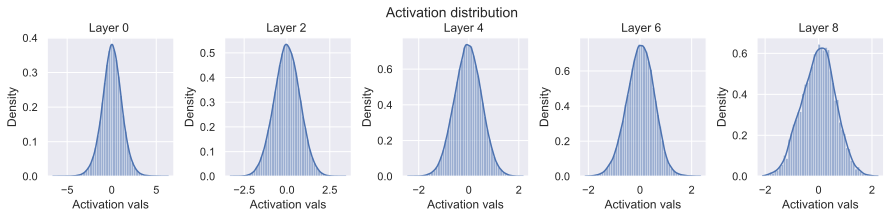

Layer 0 - Variance: 1.2806072235107422
Layer 2 - Variance: 0.5610314011573792
Layer 4 - Variance: 0.2927819490432739
Layer 6 - Variance: 0.2838048040866852
Layer 8 - Variance: 0.392678439617157


In [16]:
model, params = init_simple_model(xavier_init, act_fn=nn.tanh)
visualize_gradients(model, params, print_variance=True)
visualize_activations(model, params, print_variance=True)

Although the variance decreases over depth, it is apparent that the activation distribution becomes more focused on the low values. Therefore, our variance will stabilize around 0.25 if we would go even deeper. Hence, we can conclude that the Xavier initialization works well for Tanh networks. But what about ReLU networks? Here, we cannot take the previous assumption of the non-linearity becoming linear for small values. The ReLU activation function sets (in expectation) half of the inputs to 0 so that also the expectation of the input is not zero. However, as long as the expectation of $W$ is zero and $b=0$, the expectation of the output is zero. The part where the calculation of the ReLU initialization differs from the identity is when determining $\text{Var}(w_{ij}x_{j})$: 

$$\text{Var}(w_{ij}x_{j})=\underbrace{\mathbb{E}[w_{ij}^2]}_{=\text{Var}(w_{ij})}\mathbb{E}[x_{j}^2]-\underbrace{\mathbb{E}[w_{ij}]^2}_{=0}\mathbb{E}[x_{j}]^2=\text{Var}(w_{ij})\mathbb{E}[x_{j}^2]$$

If we assume now that $x$ is the output of a ReLU activation (from a previous layer, $x=max(0,\tilde{y})$), we can calculate the expectation as follows:


$$
\begin{split}
    \mathbb{E}[x^2] & =\mathbb{E}[\max(0,\tilde{y})^2]\\
                    & =\frac{1}{2}\mathbb{E}[{\tilde{y}}^2]\hspace{2cm}\tilde{y}\text{ is zero-centered and symmetric}\\
                    & =\frac{1}{2}\text{Var}(\tilde{y})
\end{split}$$

Thus, we see that we have an additional factor of 1/2 in the equation, so that our desired weight variance becomes $2/d_x$. This gives us the Kaiming initialization (see [He, K. et al. (2015)](https://arxiv.org/pdf/1502.01852.pdf)). Note that the Kaiming initialization does not use the harmonic mean between input and output size. In their paper (Section 2.2, Backward Propagation, last paragraph), they argue that using $d_x$ or $d_y$ both lead to stable gradients throughout the network, and only depend on the overall input and output size of the network. Hence, we can use here only the input $d_x$:

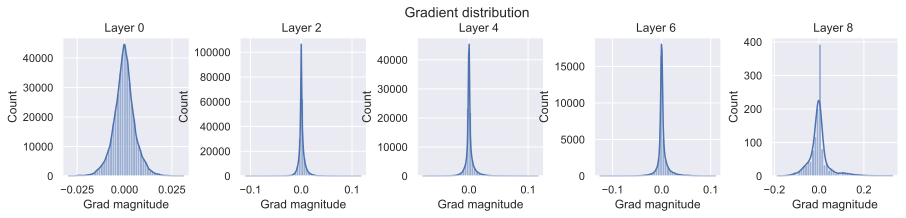

Layer 0 - Variance: 3.2594416552456096e-05
Layer 2 - Variance: 4.664550942834467e-05
Layer 4 - Variance: 6.605686212424189e-05
Layer 6 - Variance: 0.00015451121726073325
Layer 8 - Variance: 0.0025612262543290854


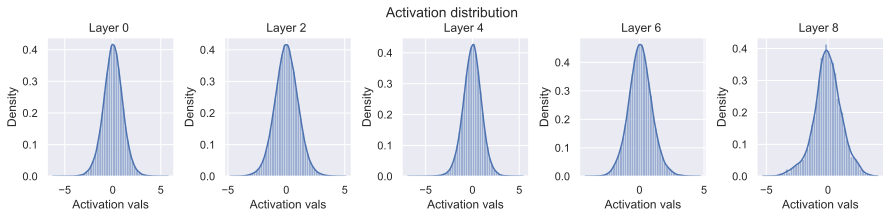

Layer 0 - Variance: 1.0483813285827637
Layer 2 - Variance: 1.0137323141098022
Layer 4 - Variance: 0.9987665414810181
Layer 6 - Variance: 0.8383973836898804
Layer 8 - Variance: 1.316560983657837


In [17]:
num_input_feats = np.prod(exmp_imgs.shape[1:])
def kaiming_init(key, shape, dtype):
    # The first layer does not have ReLU applied on its input
    # Note that this detection only works if we do not use 784 
    # feature size anywhere - better to explicitly handle 
    # layer numbers
    if shape[0] == num_input_feats:
        std = 1/np.sqrt(shape[0])
    else:
        std = np.sqrt(2/shape[0])
    return std * random.normal(key, shape, dtype)

model, params = init_simple_model(kaiming_init, act_fn=nn.relu)
visualize_gradients(model, params, print_variance=True)
visualize_activations(model, params, print_variance=True)

The variance stays stable across layers. We can conclude that the Kaiming initialization indeed works well for ReLU-based networks. Note that for Leaky-ReLU etc., we have to slightly adjust the factor of $2$ in the variance as half of the values are not set to zero anymore.

## Optimization

Besides initialization, selecting a suitable optimization algorithm can be an important choice for deep neural networks. Before taking a closer look at them, we should define code for training the models. Most of the following code is copied from the previous tutorial, and only slightly altered to fit our needs.

In [18]:
def _get_config_file(model_path, model_name):
    # Name of the file for storing hyperparameter details
    return os.path.join(model_path, model_name + ".config")

def _get_model_file(model_path, model_name):
    # Name of the file for storing network parameters
    return os.path.join(model_path, model_name + ".tar")

def _get_result_file(model_path, model_name):
    return os.path.join(model_path, model_name + "_results.json")

def load_model(model_path, model_name, state=None):
    """
    Loads a saved model from disk.

    Inputs:
        model_path - Path of the checkpoint directory
        model_name - Name of the model (str)
        state - (Optional) If given, the parameters are loaded into this training state. Otherwise,
                a new one is created alongside a network architecture.
    """
    config_file, model_file = _get_config_file(model_path, model_name), _get_model_file(model_path, model_name)
    assert os.path.isfile(config_file), f"Could not find the config file \"{config_file}\". Are you sure this is the correct path and you have your model config stored here?"
    assert os.path.isfile(model_file), f"Could not find the model file \"{model_file}\". Are you sure this is the correct path and you have your model stored here?"
    with open(config_file, "r") as f:
        config_dict = json.load(f)
    if state is None:
        net = BaseNetwork(act_fn=nn.relu, **config_dict)
        state = train_state.TrainState(step=0,
                                       params=None,
                                       apply_fn=net.apply,
                                       tx=None,
                                       opt_state=None)
    else:
        net = None
    # You can also use flax's checkpoint package. To show an alternative,
    # you can instead load the parameters simply from a pickle file.
    with open(model_file, 'rb') as f:
        params = pickle.load(f)
    state = state.replace(params=params)
    return state, net

def save_model(model, params, model_path, model_name):
    """
    Given a model, we save the parameters and hyperparameters.

    Inputs:
        model - Network object without parameters
        params - Parameters to save of the model
        model_path - Path of the checkpoint directory
        model_name - Name of the model (str)
    """
    config_dict = {'hidden_sizes': model.hidden_sizes,
                   'num_classes': model.num_classes}
    os.makedirs(model_path, exist_ok=True)
    config_file, model_file = _get_config_file(model_path, model_name), _get_model_file(model_path, model_name)
    with open(config_file, "w") as f:
        json.dump(config_dict, f)
    # You can also use flax's checkpoint package. To show an alternative,
    # you can instead save the parameters simply in a pickle file.
    with open(model_file, 'wb') as f:
        pickle.dump(params, f)
    
def calculate_loss(params, apply_fn, batch):
    imgs, labels = batch
    logits = apply_fn(params, imgs)
    loss = optax.softmax_cross_entropy_with_integer_labels(logits, labels).mean()
    acc = (labels == logits.argmax(axis=-1)).mean()
    return loss, acc

@jax.jit
def train_step(state, batch):
    grad_fn = jax.value_and_grad(calculate_loss,
                                 has_aux=True)
    (_, acc), grads = grad_fn(state.params, state.apply_fn, batch)
    state = state.apply_gradients(grads=grads)
    return state, acc

@jax.jit
def eval_step(state, batch):
    _, acc = calculate_loss(state.params, state.apply_fn, batch)
    return acc

def train_model(net, params, optimizer, model_name, max_epochs=50, batch_size=256, overwrite=False):
    """
    Train a model on the training set of FashionMNIST

    Inputs:
        net - Object of BaseNetwork
        params - The parameters to use as initialization
        optimizer - Optimizer to use
        model_name - (str) Name of the model, used for creating the checkpoint names
        max_epochs - Number of epochs we want to (maximally) train for
        batch_size - Size of batches used in training
        overwrite - Determines how to handle the case when there already exists a checkpoint. If True, it will be overwritten. Otherwise, we skip training.
    """
    file_exists = os.path.isfile(_get_model_file(CHECKPOINT_PATH, model_name))
    if file_exists and not overwrite:
        print("Model file already exists. Skipping training...")
        state = None
        with open(_get_result_file(CHECKPOINT_PATH, model_name), "r") as f:
            results = json.load(f)
    else:
        if file_exists:
            print("Model file exists, but will be overwritten...")

        # Initializing training state
        results = None
        state = train_state.TrainState.create(apply_fn=net.apply,
                                              params=params,
                                              tx=optimizer)

        # Defining data loader
        train_loader_local = data.DataLoader(train_set,
                                             batch_size=batch_size,
                                             shuffle=True,
                                             drop_last=True,
                                             collate_fn=numpy_collate,
                                             generator=torch.Generator().manual_seed(42))

        train_scores = []
        val_scores = []
        best_val_epoch = -1
        for epoch in range(max_epochs):
            ############
            # Training #
            ############
            train_acc = 0.
            for batch in tqdm(train_loader_local, desc=f"Epoch {epoch+1}", leave=False):
                state, acc = train_step(state, batch)
                train_acc += acc
            train_acc /= len(train_loader_local)
            train_scores.append(train_acc.item())

            ##############
            # Validation #
            ##############
            val_acc = test_model(state, val_loader)
            val_scores.append(val_acc)
            print(f"[Epoch {epoch+1:2d}] Training accuracy: {train_acc:05.2%}, Validation accuracy: {val_acc:4.2%}")

            if len(val_scores) == 1 or val_acc > val_scores[best_val_epoch]:
                print("\t   (New best performance, saving model...)")
                save_model(net, state.params, CHECKPOINT_PATH, model_name)
                best_val_epoch = epoch

    state, _ = load_model(CHECKPOINT_PATH, model_name, state=state)
    if results is None:
        test_acc = test_model(state, test_loader)
        results = {"test_acc": test_acc, "val_scores": val_scores, 
                   "train_scores": train_scores}
        with open(_get_result_file(CHECKPOINT_PATH, model_name), "w") as f:
            json.dump(results, f)

    # Plot a curve of the validation accuracy
    sns.set()
    plt.plot([i for i in range(1,len(results["train_scores"])+1)], results["train_scores"], label="Train")
    plt.plot([i for i in range(1,len(results["val_scores"])+1)], results["val_scores"], label="Val")
    plt.xlabel("Epochs")
    plt.ylabel("Validation accuracy")
    plt.ylim(min(results["val_scores"]), max(results["train_scores"])*1.01)
    plt.title(f"Validation performance of {model_name}")
    plt.legend()
    plt.show()
    plt.close()

    print((f" Test accuracy: {results['test_acc']:4.2%} ").center(50, "=")+"\n")
    return state


def test_model(state, data_loader):
    """
    Test a model on a specified dataset.

    Inputs:
        state - Training state including parameters and model apply function.
        data_loader - DataLoader object of the dataset to test on (validation or test)
    """
    true_preds, count = 0., 0
    for batch in data_loader:
        acc = eval_step(state, batch)
        batch_size = batch[0].shape[0]
        true_preds += acc * batch_size
        count += batch_size
    test_acc = true_preds / count
    return test_acc.item()

First, we need to understand what an optimizer actually does. The optimizer is responsible to update the network's parameters given the gradients. Hence, we effectively implement a function $w^{t} = f(w^{t-1}, g^{t}, ...)$ with $w$ being the parameters, and $g^{t} = \nabla_{w^{(t-1)}} \mathcal{L}^{(t)}$ the gradients at time step $t$. A common, additional parameter to this function is the learning rate, here denoted by $\eta$. Usually, the learning rate can be seen as the "step size" of the update. A higher learning rate means that we change the weights more in the direction of the gradients, a smaller means we take shorter steps. 

As most optimizers only differ in the implementation of $f$, we can define a template for an optimizer in JAX below. Note that in comparison to PyTorch, the optimizers must be functional and have no effects outside the function. Hence, we follow the basic implementation principles of [optax](https://optax.readthedocs.io/en/latest/) and define an optimizer to be a tuple of two main functions:

* `init`: Given a set of parameters, initialize any state variables that the optimizer may need. While is might not be necessary for the simplest optimizers, more sophisticated like Adam need to keep track of gradient statistics, which can be initialized here.
* `update`: Given the gradients, the optimizer state, and the parameters, return the updates that should be applied to the parameters, and an updated optimizer state. 

The updates can be applied to the parameters using `optax.apply_updates(params, updates)` which adds each update value to its respective parameter. In simplified form, it applies `tree_map(lambda p, u: p + u, params, updates)`. As a reminder, `jax.tree_util.tree_map` is a function that runs over PyTrees and applies a function to all leafs, returning a new PyTree with the results. If we input multiple PyTrees, it runs over them synchronously and applies the functions on tuples of leafs, one of each PyTree. In the function above, this means that a new PyTree is created for which each leaf has the sum of the respective leaf in `params` and `updates`.

In contrast to PyTorch, there is no `zero_grad` function since the gradients are the output of a separate gradient function, not an object-based backpropagation through a dynamic computation graph. The template is setup below:

In [19]:
class Optimizer(NamedTuple):
    # Given the parameters, initialize any optimizer state as tuple
    init : Callable[[PyTree], tuple]
    # Given the gradients, optimizer state, and evt. parameters, return
    # the parameter updates and new optimizer state
    update : Callable[[PyTree, tuple, Optional[PyTree]], Tuple[PyTree, tuple]]

The first optimizer we are going to implement is the standard Stochastic Gradient Descent (SGD). SGD updates the parameters using the following equation:

$$
\begin{split}
    w^{(t)} & = w^{(t-1)} - \eta \cdot g^{(t)}
\end{split}
$$

As simple as the equation is also our implementation of SGD:

In [20]:
def sgd(lr):
    def init(params):
        return tuple()
        
    def update(updates, state, params=None):
        updates = tree_map(lambda u: -lr * u, updates)
        return updates, state
    
    return Optimizer(init, update)

Note that we define SGD as a function that returns a tuple of the init and update function, which depends on the input parameter `lr`, i.e., the learning rate. SGD does not have any state it needs to keep track of. Hence, the init function returns an empty tuple. The update function simply multiplies all gradients with the learning rate. The negative sign is needed since the `apply_updates` function *adds* the updates to the parameters, not subtracts.

In the lecture, we also have discussed the concept of momentum which replaces the gradient in the update by an exponential average of all past gradients including the current one:

$$
\begin{split}
    m^{(t)} & = \beta_1 m^{(t-1)} + (1 - \beta_1)\cdot g^{(t)}\\
    w^{(t)} & = w^{(t-1)} - \eta \cdot m^{(t)}\\
\end{split}
$$

Let's also implement it below:

In [21]:
def sgd_momentum(lr, momentum=0.0):
    def init(params):
        param_momentum = tree_map(jnp.zeros_like, params)
        return param_momentum
        
    def update(updates, state, params=None):
        state = tree_map(lambda m, g: (1 - momentum) * g + momentum * m,
                         state,
                         updates)
        updates = tree_map(lambda m: - lr * m,
                           state)
        return updates, state
    
    return Optimizer(init, update)

We track the momentum parameters $m^{(t)}$ in a PyTree, which is initialized with all zeros, but with the same shape and structure as the parameters. At each update iteration, we update our momentum parameters with above's equation, and use it to calculate the new updates.

As a third and final optimizer, we arrive at Adam. Adam combines the idea of momentum with an adaptive learning rate, which is based on an exponential average of the squared gradients, i.e. the gradients norm. Furthermore, we add a bias correction for the momentum and adaptive learning rate for the first iterations:

$$
\begin{split}
    m^{(t)} & = \beta_1 m^{(t-1)} + (1 - \beta_1)\cdot g^{(t)}\\
    v^{(t)} & = \beta_2 v^{(t-1)} + (1 - \beta_2)\cdot \left(g^{(t)}\right)^2\\
    \hat{m}^{(t)} & = \frac{m^{(t)}}{1-\beta^{t}_1}, \hat{v}^{(t)} = \frac{v^{(t)}}{1-\beta^{t}_2}\\
    w^{(t)} & = w^{(t-1)} - \frac{\eta}{\sqrt{\hat{v}^{(t)}} + \epsilon}\circ \hat{m}^{(t)}\\
\end{split}
$$

Epsilon is a small constant used to improve numerical stability for very small gradient norms. Remember that the adaptive learning rate does not replace the learning rate hyperparameter $\eta$, but rather acts as an extra factor and ensures that the gradients of various parameters have a similar norm. 

In [22]:
def adam(lr, beta1=0.9, beta2=0.999, eps=1e-8):
    def init(params):
        step = 0.
        param_momentum = tree_map(jnp.zeros_like, params)
        param_2nd_momentum = tree_map(jnp.zeros_like, params)
        return (step, param_momentum, param_2nd_momentum)
    
    def update(updates, state, params=None):
        # Update momentum and adapt. lr
        step, param_momentum, param_2nd_momentum = state
        step += 1
        param_momentum = tree_map(lambda m, g: (1 - beta1) * g + beta1 * m,
                                  param_momentum,
                                  updates)
        param_2nd_momentum = tree_map(lambda m2, g: (1 - beta2) * g**2 + beta2 * m2,
                                      param_2nd_momentum,
                                      updates)
        # Calculate update for single parameter
        def update_param(m, m2):
            # Bias correction
            m /= 1 - beta1 ** step
            m2 /= 1 - beta2 ** step
            return - m * lr / (jnp.sqrt(m2) + eps)
        # Update for all parameters
        updates = tree_map(update_param,
                           param_momentum,
                           param_2nd_momentum)
        return updates, (step, param_momentum, param_2nd_momentum)
    
    return Optimizer(init, update)

Our state consists of a counter `step` that keeps track of the time step $t$, the momentums $m^{(t)}$ and the second momentum/adaptive learning rate parameters $v^{(t)}$. At each update step, we update $m^{(t)}$ and $v^{(t)}$, and afterwards calculate the updates for each parameters based on $m^{(t)}$ and $v^{(t)}$.

### Comparing optimizers on model training

After we have implemented three optimizers (SGD, SGD with momentum, and Adam), we can start to analyze and compare them. 
First, we test them on how well they can optimize a neural network on the FashionMNIST dataset. We use again our linear network, this time with a ReLU activation and the kaiming initialization, which we have found before to work well for ReLU-based networks. Note that the model is over-parameterized for this task, and we can achieve similar performance with a much smaller network (for example `100,100,100`). However, our main interest is in how well the optimizer can train *deep* neural networks, hence the over-parameterization.

In [23]:
model, params = init_simple_model(kaiming_init, act_fn=nn.relu)

For a fair comparison, we train the exact same model with the same seed with the three optimizers below. Feel free to change the hyperparameters if you want, the models are relatively fast to train.

Model file already exists. Skipping training...


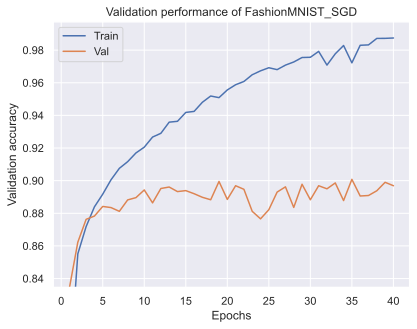

============= Test accuracy: 89.61% ==============



In [24]:
_ = train_model(model, params, sgd(lr=1e-1),
                "FashionMNIST_SGD",  
                max_epochs=40, batch_size=256)

Model file already exists. Skipping training...


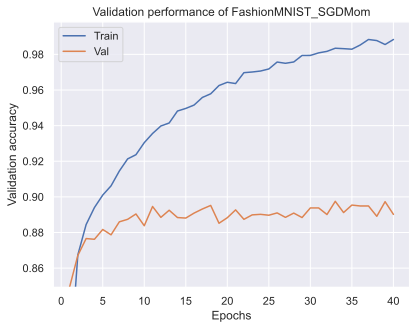

============= Test accuracy: 89.30% ==============



In [25]:
_ = train_model(model, params, sgd_momentum(lr=1e-1, momentum=0.9),
                "FashionMNIST_SGDMom",  
                max_epochs=40, batch_size=256)

Model file already exists. Skipping training...


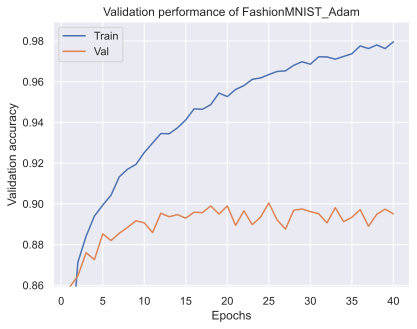

============= Test accuracy: 89.06% ==============



In [26]:
_ = train_model(model, params, adam(lr=1e-3), 
                "FashionMNIST_Adam", 
                max_epochs=40, batch_size=256)

The result is that all optimizers perform similarly well with the given model. The differences are too small to find any significant conclusion. However, keep in mind that this can also be attributed to the initialization we chose. When changing the initialization to worse (e.g. constant variance), Adam usually shows to be more robust because of its adaptive learning rate. To show the specific benefits of the optimizers, we will continue to look at some possible loss surfaces in which momentum and adaptive learning rate are crucial.

### Pathological curvatures

A pathological curvature is a type of surface that is similar to ravines and is particularly tricky for plain SGD optimization. In words, pathological curvatures typically have a steep gradient in one direction with an optimum at the center, while in a second direction we have a slower gradient towards a (global) optimum. Let's first create an example surface of this and visualize it:

In [27]:
def pathological_curve_loss(w1, w2):
    # Example of a pathological curvature. There are many more possible, feel free to experiment here!
    x1_loss = nn.tanh(w1)**2 + 0.01 * jnp.abs(w1)
    x2_loss = nn.sigmoid(w2)
    return x1_loss + x2_loss

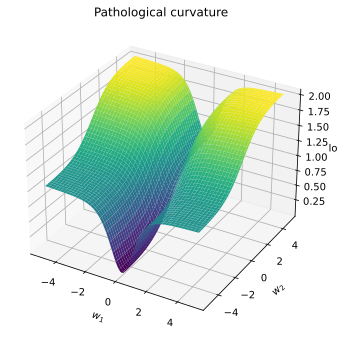

In [28]:
def plot_curve(curve_fn, x_range=(-5,5), y_range=(-5,5), plot_3d=False, cmap=cm.viridis, title="Pathological curvature"):
    fig = plt.figure()
    ax = plt.axes(projection='3d') if plot_3d else plt.axes()
    
    x = np.arange(x_range[0], x_range[1], (x_range[1]-x_range[0])/100.)
    y = np.arange(y_range[0], y_range[1], (y_range[1]-y_range[0])/100.)
    x, y = np.meshgrid(x, y)
    z = curve_fn(x, y)
    z = jax.device_get(z)
    
    if plot_3d:
        ax.plot_surface(x, y, z, cmap=cmap, linewidth=1, color="#000", antialiased=False)
        ax.set_zlabel("loss")
    else:
        ax.imshow(z[::-1], cmap=cmap, extent=(x_range[0], x_range[1], y_range[0], y_range[1]))
    plt.title(title)
    ax.set_xlabel(r"$w_1$")
    ax.set_ylabel(r"$w_2$")
    plt.tight_layout()
    return ax

sns.reset_orig()
_ = plot_curve(pathological_curve_loss, plot_3d=True)
plt.show()

In terms of optimization, you can image that $w_1$ and $w_2$ are weight parameters, and the curvature represents the loss surface over the space of $w_1$ and $w_2$. Note that in typical networks, we have many, many more parameters than two, and such curvatures can occur in multi-dimensional spaces as well.

Ideally, our optimization algorithm would find the center of the ravine and focuses on optimizing the parameters towards the direction of $w_2$. However, if we encounter a point along the ridges, the gradient is much greater in $w_1$ than $w_2$, and we might end up jumping from one side to the other. Due to the large gradients, we would have to reduce our learning rate slowing down learning significantly.

To test our algorithms, we can implement a simple function to train two parameters on such a surface:

In [29]:
def train_curve(optimizer, curve_func=pathological_curve_loss, num_updates=100, init=[5,5]):
    """
    Inputs:
        optimizer - Optimizer to use
        curve_func - Loss function (e.g. pathological curvature)
        num_updates - Number of updates/steps to take when optimizing 
        init - Initial values of parameters. Must be a list/tuple with two elements representing w_1 and w_2
    Outputs:
        Numpy array of shape [num_updates, 3] with [t,:2] being the parameter values at step t, and [t,2] the loss at t.
    """
    weights = jnp.array(init, dtype=jnp.float32)
    grad_fn = jax.jit(jax.value_and_grad(lambda w: curve_func(w[0], w[1])))
    opt_state = optimizer.init(weights)
    
    list_points = []
    for _ in range(num_updates):
        loss, grads = grad_fn(weights)
        list_points.append(jnp.concatenate([weights, loss[None]], axis=0))
        updates, opt_state = optimizer.update(grads, opt_state)
        weights = optax.apply_updates(weights, updates)
    points = jnp.stack(list_points, axis=0)
    points = jax.device_get(points)
    return points

Next, let's apply the different optimizers on our curvature. Note that we set a much higher learning rate for the optimization algorithms as you would in a standard neural network. This is because we only have 2 parameters instead of tens of thousands or even millions.

In [30]:
SGD_points = train_curve(sgd(lr=10))
SGDMom_points = train_curve(sgd_momentum(lr=10, momentum=0.9))
Adam_points = train_curve(adam(lr=1))

To understand best how the different algorithms worked, we visualize the update step as a line plot through the loss surface. We will stick with a 2D representation for readability.

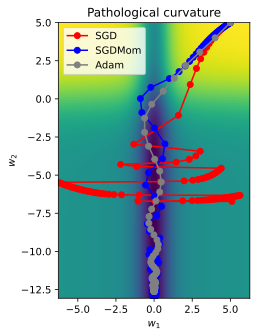

In [31]:
all_points = np.concatenate([SGD_points, SGDMom_points, Adam_points], axis=0)
ax = plot_curve(pathological_curve_loss,
                x_range=(-np.absolute(all_points[:,0]).max(), np.absolute(all_points[:,0]).max()),
                y_range=(all_points[:,1].min(), all_points[:,1].max()),
                plot_3d=False)
ax.plot(SGD_points[:,0], SGD_points[:,1], color="red", marker="o", zorder=1, label="SGD")
ax.plot(SGDMom_points[:,0], SGDMom_points[:,1], color="blue", marker="o", zorder=2, label="SGDMom")
ax.plot(Adam_points[:,0], Adam_points[:,1], color="grey", marker="o", zorder=3, label="Adam")
plt.legend()
plt.show()

We can clearly see that SGD is not able to find the center of the optimization curve and has a problem converging due to the steep gradients in $w_1$. In contrast, Adam and SGD with momentum nicely converge as the changing direction of $w_1$ is canceling itself out. On such surfaces, it is crucial to use momentum.

### Steep optima

A second type of challenging loss surfaces are steep optima. In those, we have a larger part of the surface having very small gradients while around the optimum, we have very large gradients. For instance, take the following loss surfaces:

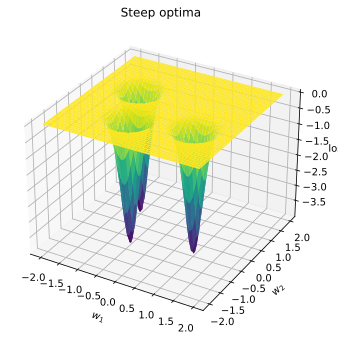

In [32]:
def bivar_gaussian(w1, w2, x_mean=0.0, y_mean=0.0, x_sig=1.0, y_sig=1.0):
    norm = 1 / (2 * np.pi * x_sig * y_sig)
    x_exp = (-1 * (w1 - x_mean)**2) / (2 * x_sig**2)
    y_exp = (-1 * (w2 - y_mean)**2) / (2 * y_sig**2)
    return norm * jnp.exp(x_exp + y_exp)

def comb_func(w1, w2):
    z = -bivar_gaussian(w1, w2, x_mean=1.0, y_mean=-0.5, x_sig=0.2, y_sig=0.2)
    z -= bivar_gaussian(w1, w2, x_mean=-1.0, y_mean=0.5, x_sig=0.2, y_sig=0.2)
    z -= bivar_gaussian(w1, w2, x_mean=-0.5, y_mean=-0.8, x_sig=0.2, y_sig=0.2)
    return z

_ = plot_curve(comb_func, x_range=(-2,2), y_range=(-2,2), plot_3d=True, title="Steep optima")

Most of the loss surface has very little to no gradients. However, close to the optima, we have very steep gradients. To reach the minimum when starting in a region with lower gradients, we expect an adaptive learning rate to be crucial. To verify this hypothesis, we can run our three optimizers on the surface:

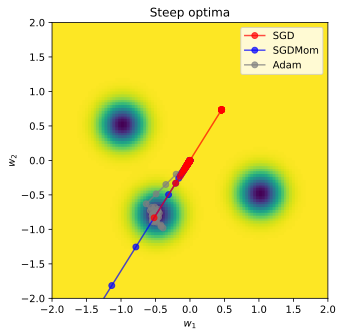

In [33]:
SGD_points = train_curve(sgd(lr=.5), comb_func, init=[0,0])
SGDMom_points = train_curve(sgd_momentum(lr=1, momentum=0.9), comb_func, init=[0,0])
Adam_points = train_curve(adam(lr=0.2), comb_func, init=[0,0])

all_points = np.concatenate([SGD_points, SGDMom_points, Adam_points], axis=0)
ax = plot_curve(comb_func,
                x_range=(-2, 2),
                y_range=(-2, 2),
                plot_3d=False,
                title="Steep optima")
ax.plot(SGD_points[:,0], SGD_points[:,1], color="red", marker="o", zorder=3, label="SGD", alpha=0.7)
ax.plot(SGDMom_points[:,0], SGDMom_points[:,1], color="blue", marker="o", zorder=2, label="SGDMom", alpha=0.7)
ax.plot(Adam_points[:,0], Adam_points[:,1], color="grey", marker="o", zorder=1, label="Adam", alpha=0.7)
ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)
plt.legend()
plt.show()

SGD first takes very small steps until it touches the border of the optimum. First reaching a point around $(-0.75,-0.5)$, the gradient direction has changed and pushes the parameters to $(0.8,0.5)$ from which SGD cannot recover anymore (only with many, many steps). A similar problem has SGD with momentum, only that it continues the direction of the touch of the optimum. The gradients from this time step are so much larger than any other point that the momentum $m_t$ is overpowered by it. Finally, Adam is able to converge in the optimum showing the importance of adaptive learning rates.

### What optimizer to take

After seeing the results on optimization, what is our conclusion? Should we always use Adam and never look at SGD anymore? The short answer: no. There are many papers saying that in certain situations, SGD (with momentum) generalizes better where Adam often tends to overfit [5,6]. This is related to the idea of finding wider optima. For instance, see the illustration of different optima below (credit: [Keskar et al., 2017](https://arxiv.org/pdf/1609.04836.pdf)):

<center width="100%"><img src="../../tutorial4/flat_vs_sharp_minima.svg" width="500px"></center>

The black line represents the training loss surface, while the dotted red line is the test loss. Finding sharp, narrow minima can be helpful for finding the minimal training loss. However, this doesn't mean that it also minimizes the test loss as especially flat minima have shown to generalize better. You can imagine that the test dataset has a slightly shifted loss surface due to the different examples than in the training set. A small change can have a significant influence for sharp minima, while flat minima are generally more robust to this change. 

In the next tutorial, we will see that some network types can still be better optimized with SGD and learning rate scheduling than Adam. Nevertheless, Adam is the most commonly used optimizer in Deep Learning as it usually performs better than other optimizers, especially for deep networks.

## Conclusion

In this tutorial, we have looked at initialization and optimization techniques for neural networks. We have seen that a good initialization has to balance the preservation of the gradient variance as well as the activation variance. This can be achieved with the Xavier initialization for tanh-based networks, and the Kaiming initialization for ReLU-based networks. In optimization, concepts like momentum and adaptive learning rate can help with challenging loss surfaces but don't guarantee an increase in performance for neural networks.


## References

[1] Glorot, Xavier, and Yoshua Bengio. "Understanding the difficulty of training deep feedforward neural networks." Proceedings of the thirteenth international conference on artificial intelligence and statistics. 2010. [link](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf)

[2] He, Kaiming, et al. "Delving deep into rectifiers: Surpassing human-level performance on imagenet classification." Proceedings of the IEEE international conference on computer vision. 2015. [link](https://www.cv-foundation.org/openaccess/content_iccv_2015/html/He_Delving_Deep_into_ICCV_2015_paper.html)

[3] Kingma, Diederik P. & Ba, Jimmy. "Adam: A Method for Stochastic Optimization." Proceedings of the third international conference for learning representations (ICLR). 2015. [link](https://arxiv.org/abs/1412.6980)

[4] Keskar, Nitish Shirish, et al. "On large-batch training for deep learning: Generalization gap and sharp minima." Proceedings of the fifth international conference for learning representations (ICLR). 2017. [link](https://arxiv.org/abs/1609.04836)

[5] Wilson, Ashia C., et al. "The Marginal Value of Adaptive Gradient Methods in Machine Learning." Advances in neural information processing systems. 2017. [link](https://papers.nips.cc/paper/7003-the-marginal-value-of-adaptive-gradient-methods-in-machine-learning.pdf)

[6] Ruder, Sebastian. "An overview of gradient descent optimization algorithms." arXiv preprint. 2017. [link](https://arxiv.org/abs/1609.04747)

---

[![Star our repository](https://img.shields.io/static/v1.svg?logo=star&label=⭐&message=Star%20Our%20Repository&color=yellow)](https://github.com/phlippe/uvadlc_notebooks/)  If you found this tutorial helpful, consider ⭐-ing our repository.    
[![Ask questions](https://img.shields.io/static/v1.svg?logo=star&label=❔&message=Ask%20Questions&color=9cf)](https://github.com/phlippe/uvadlc_notebooks/issues)  For any questions, typos, or bugs that you found, please raise an issue on GitHub. 

---